# Classificador Estatístico de Notícias

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
from algorithms import utils as ut

#Imports nltk ---------------------------------------------
import nltk
from nltk.stem.snowball import SnowballStemmer

#Imports sklearn ------------------------------------------

#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# #naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# #regressão logística
from sklearn.linear_model import LogisticRegression


from algorithms.NearestNeighbors import ClusterNNClassifier

### Importando stopwords e stemmer

Precisaremos destes módulos para processar os textos das notícias

In [2]:
stemmer = SnowballStemmer('portuguese')
stopwords = nltk.corpus.stopwords.words('portuguese')

### Importando notícias

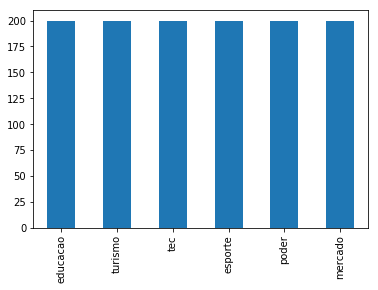

In [3]:
news,labels = ut.load_articles("/Users/lucasperes/notebooks/articles-filtered-200.tsv",plot=True)

## Iniciando pré-processamento

### Processando notícias

In [4]:
news[0], labels[0]

('Com a possibilidade de uma condenação impedir sua candidatura em 2018, o ex-presidente Luiz Inácio Lula da Silva fez, nesta segunda (9), um discurso inflamado contra a Lava Jato, no qual disse saber que está "lascado", exigiu um pedido de desculpas do juiz Sergio Moro e afirmou que, mesmo fora da disputa pelo Planalto, será um cabo eleitoral expressivo para a sucessão de Michel Temer.  Segundo o petista, réu em sete ações penais, o objetivo de Moro é impedir sua candidatura no ano que vem, desidratando-o, inclusive, no apoio a um nome alternativo, como o do ex-prefeito de São Paulo Fernando Haddad (PT), caso ele não possa concorrer à Presidência.  "Eu sei que tô lascado, todo dia tem um processo. Eu não quero nem que Moro me absolva, eu só quero que ele peça desculpas", disse Lula durante um seminário sobre educação em Brasília. "Eles [investigadores] chegam a dizer: \'Ah, se o Lula não for candidato, ele não vai ter força como cabo eleitoral\'. Testem", completou o petista.  Para o 

Precisamos processar os textos a fim de remover palavras(ou **tokens**) que não tem grande contribuição para a semântica das notícias, como os artigos, preposições, etc.

Outra coisa interessante que podemos fazer é a **stemização** dos termos: palavras como *deputado* e *deputada*, por exemplo, podem indicar o mesmo tema: **poder**(política). O *stemmer* será responsável por extrair, de cada palavra, apenas seus radicais, a fim de fazer palavras como *deputado* e *deputada* serem escritas da mesma maneira.

In [5]:
#Removendo stopwords,"tokenizando", aplicando stemmer e removendo caracteres indesejáveis
undesired = [',','.',"'",'"','´','`',';',':','-','?','!','%','(',')','\t','\n']
data_processed = []
for k in news:
    tokenizedText = nltk.word_tokenize(k,language='portuguese')
    stemmedText = [stemmer.stem(t) for t in tokenizedText if t not in stopwords and not t in undesired]
    data_processed.append(" ".join(stemmedText))
    
# #Reescrevendo noticias
# new_data = []
# for data in data_processed:
#     new_data.append(" ".join(data))

# data_processed = new_data

data_processed[0],labels[0]

("com possibil conden imped candidatur 2018 ex-president luiz ináci lul silv fez nest segund 9 discurs inflam contr lav jat diss sab `` lasc '' exig ped desculp juiz sergi mor afirm disput planalt cab eleitoral express sucessã michel tem segund petist réu set açõ pen objet mor é imped candidatur ano vem desidratando- inclusiv apoi nom altern ex-prefeit sã paul fern haddad pt cas poss concorr president `` eu sei tô lasc tod dia process eu quer mor absolv quer pec desculp '' diss lul durant seminári sobr educ brasíl `` eles [ investig ] cheg diz 'ah lul candidat vai ter forc cab eleitoral test '' complet petist par ex-president mor usou `` ment cont políc federal ministéri públic '' julgá-l condená-l nov anos seis mes prisã cas tríplex guaruj sp o ex-president diss aind ter `` med '' investig acord acostum `` mex deput senador '' tem apur `` eu quer saib seguint acostum lid deput med mex senador têm med quer diz respeit profund respeit leis ajud cri respeit respeit respeit '' afirm petis

## Iniciando classificação

### Permutando as notícias

In [6]:
#Permutação dos dados
temp = np.column_stack((data_processed,labels))
temp = np.random.permutation(temp)
data_processed = temp[:,0]
labels = temp[:,1]

### Gerando matrizes dos dados

Para representar os textos de forma vetorial, utilizaremos a técnica *TF-IDF*(*Term Frequency – Inverse Document Frequency*). A técnica consistem em representar as notícias como um vetor de ocorrência das palavras. Dado uma notícia, o *i-ésimo* elemento do vetor representa a ocorrência da *i-ésima* palavra. O *IDF* é responsável por normalizar esses valores, analisando não só a ocorrência de uma palavra no texto, mas também em todos os outros.

In [7]:
cv = CountVectorizer()

X_counts = cv.fit_transform(data_processed)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_counts)
text_tf = tf_transformer.transform(X_counts)

print("Total de tokens: {}".format(text_tf.shape[1]))

Total de tokens: 21189


### Separando features de treino e teste

In [8]:
#Separação das labels de treino e teste
p = 0.8
size = len(data_processed)
partition = math.floor(size*p)

trainLabels = labels[:partition]
trainText = text_tf[:partition]

testText = text_tf[partition:]
testLabels = labels[partition:]

### Classificando

Agora que temos uma representação vetorial para as notícias, podemos aplicar os classificadores conhecidos.

Neste experimento, como estamos usando ocorrência de palavras nos textos, utilizaremos variações do algoritmo de *Naive Bayes*, assumindo distribuições Gaussianas, Bernoulli e Multinomial. 

Utilizamos também, para fins de comparação, os métodos de Distância Mínima ao Centróide, um algoritmo similar ao *KNN*, porém, ao invés de utilizar todos os dados, utilizamos os centróides. Outro método também utilizado foi a Regressão Logística.

In [9]:
try:
    trainText = trainText.toarray()
    testText = testText.toarray()
    
except Exception:
    pass
    
models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Nearest Centroid Classifier": ClusterNNClassifier(),
#     "KNN(k=11)": KNNClassifier(k=11),
    "Logistic Regression Classifier(alpha = 0.5)": LogisticRegression(C=.5)
}

for name in models:
    model = models[name]
    model.fit(trainText,trainLabels)
    print("{} score: {}%".format(name,model.score(testText,testLabels)*100))

Gaussian Naive Bayes score: 88.33333333333333%
Multinomial Naive Bayes score: 93.75%
Bernoulli Naive Bayes score: 90.83333333333333%
Nearest Centroid Classifier score: 92.5%
Logistic Regression Classifier(alpha = 0.5) score: 94.16666666666667%


### Análise da Matriz de Confusão

In [10]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        nan_indexes = np.isnan(cm)
        cm[nan_indexes] = 0

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

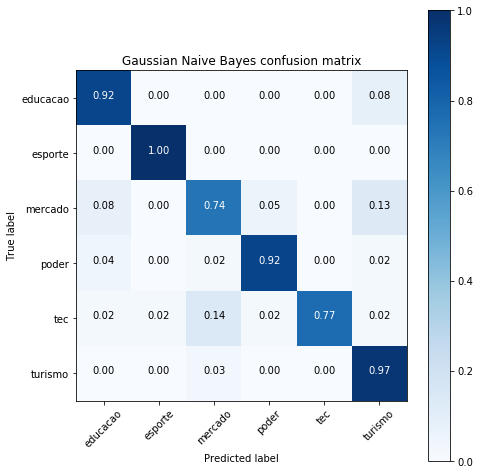

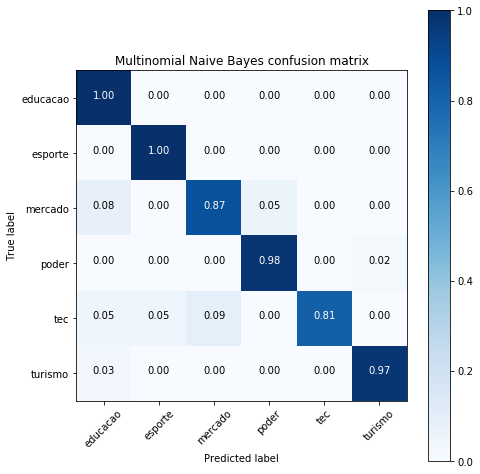

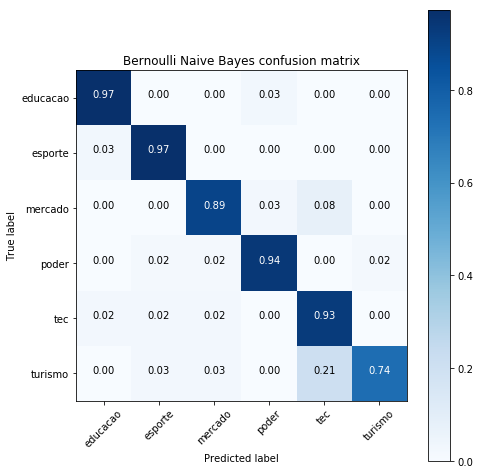

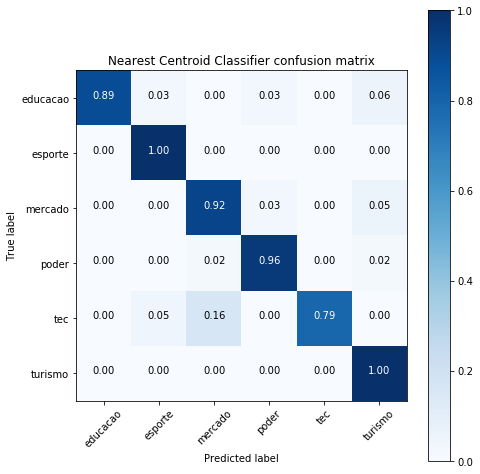

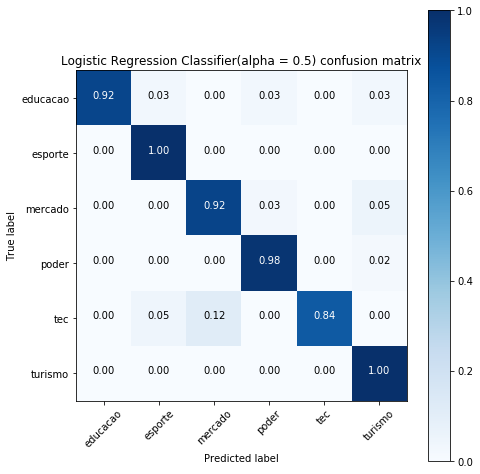

In [11]:
class_names = np.unique(labels)
for name in models:
    model = models[name]
    y_predict = model.predict(testText) if not name == "Nearest Centroid Classifier" \
        else [model.predict(x) for x in testText]
        
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(testLabels, y_predict)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='{} confusion matrix'.format(name))

    _ = plt.show()

## Outros testes com os classificadores

Implementamos as funções a baixo a fim de podermos agilizar o processamento de novas notícias individualmente e classificá-las

In [12]:
def process_new(new):
    tokenizedText = nltk.word_tokenize(new)
    stemmedText = [stemmer.stem(t) for t in tokenizedText if t not in stopwords]

    text = [word for word in stemmedText if not word in undesired]
    text = " ".join(text)
    cv_text = cv.transform([text])
    
    return tf_transformer.transform(cv_text)

def classify_new(new):
    processed_new = process_new(new).toarray()
    
    for name in models:
        model = models[name]
        y = model.predict(processed_new)
        
        if len(y) == 1:
            y = y[0]
        
        print("{}: {}".format(name,y))

### Teste com uma notícia

In [13]:
new = """A rodada deste fim de semana ainda não confirmou o título do Corinthians, que segue com mais de 99% de chance 
de conquista, contra menos de 1% do Atlético Mineiro segundo o site Infobola, do matemático Tristão Garcia. 
Para o Galo, o triunfo sofre o Figueirense, com um gol no finzinho, além de manter a chance matemática de 
título para os mineiros, também confirmou o time com uma das vagas para a Libertadores. Para as vagas que 
restam para a competição sul-americana, o Grêmio, embora derrotado pelo Sport, segue bem tranquilo. Só uma 
catástrofe tira o time gaúcho da vaga 3 e por isso suas chances estão em 96%. Daí para a frente, a coisa embola 
um pouco. A rodada fez o leque de possibilidades se ampliar. Um exemplo é que o Flamengo saiu do traço e voltou 
a ter uma pequena chance após a sua vitória e os resultados dos rivais. Afinal, quem estava bem à frente não venceu.
Santos, São Paulo e Internacional seguem bem cotados. O Sport (que tem uma tabela bem complicada e por isso está 
com apenas 7%) precisa de mais um bom resultado na próxima rodada para se aproximar da trinca. Ponte Preta, 
Palmeiras, Cruzeiro e o Rubro-Negro (que respira graças ao seu bom número de vitórias que lhe dará vantagem caso 
empate em pontos contra qualquer um dos demais concorrentes) respiram por aparelho. Na turma que tenta escapar da 
degola, o Vasco segue construindo notável reação. Embora ainda apareça com 84% de possibilidade de rebaixamento,
o Cruz-Maltino conseguiu resultado pouco esperado, a vitória sobre o Palmeiras fora de casa, e pode dar um 
supersalto rumo à salvação já na próxima rodada quando ocorrem dois jogos de rivais diretos pelo rebaixamento: 
Goiás x Coritiba e Avaí x Joinville. Olho vivo no Figueirense. A série de resultados ruins fez o time encostar 
muito no bolo dos desesperados. Já a Chapecoense, com a vitória sobre o Fluminense, se despediu dessa briga."""

classify_new(new)

Gaussian Naive Bayes: esporte
Multinomial Naive Bayes: esporte
Bernoulli Naive Bayes: esporte
Nearest Centroid Classifier: esporte
Logistic Regression Classifier(alpha = 0.5): esporte


### Classificando outro dataset

Podemos utilizar um outro dataset para testarmos nossos classificadores. Para isso, precisamos mapear algumas nas categorias do novo dataset para as treinadas.

In [14]:
trained_labels = list(set(trainLabels))
print("Labels learned: {}".format(trained_labels))
news, labels = ut.load_xml_news("datasets/news_data.xml", plot=False)
print("Labels in dataset: {}".format(list(set(labels))))
labels = np.array(labels)
labels[labels=="economia"] = "mercado"
labels[labels=="política"] = "poder"
labels[labels=="tecnologia"] = "tec"
labels[labels=="educação"] = "educacao"

bool_array = np.array([l in trained_labels for l in labels])

news = list(np.array(news)[bool_array])
news = [process_new(new).toarray() for new in news]

labels = labels[bool_array]

Labels learned: ['esporte', 'poder', 'tec', 'mercado', 'turismo', 'educacao']
Labels in dataset: ['esporte', 'tecnologia', 'música', 'economia', 'tv', 'moda', 'empregos', 'ciência', 'política', 'educação', 'carros', 'saúde', 'entretenimento', 'internacional']


Agora, vamos analizar a acurácia e a Matriz de Confusão de cada um dos modelos

Gaussian Naive Bayes's score: 61.13879003558719%


/Users/lucasperes/miniconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Multinomial Naive Bayes's score: 84.05693950177935%
Bernoulli Naive Bayes's score: 70.67615658362989%
Nearest Centroid Classifier's score: 80.64056939501779%
Logistic Regression Classifier(alpha = 0.5)'s score: 82.91814946619218%


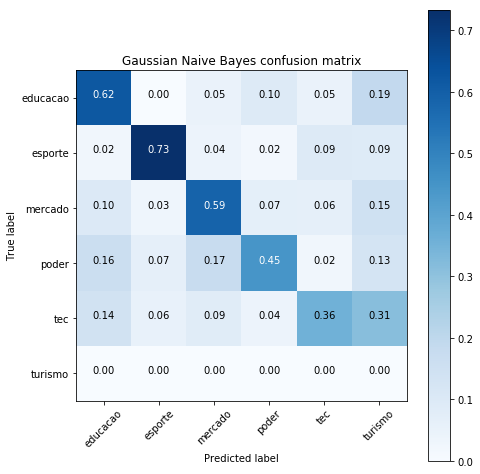

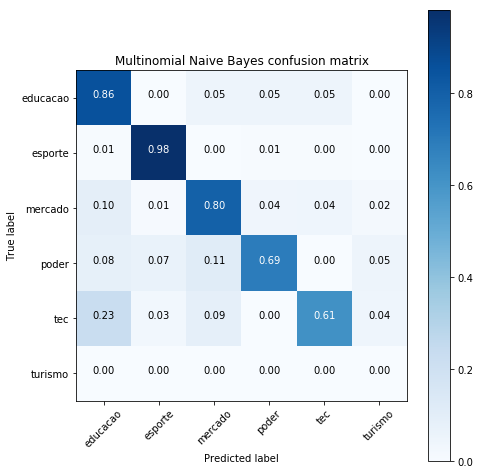

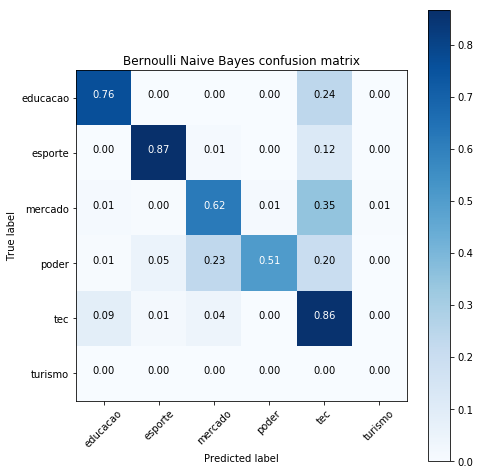

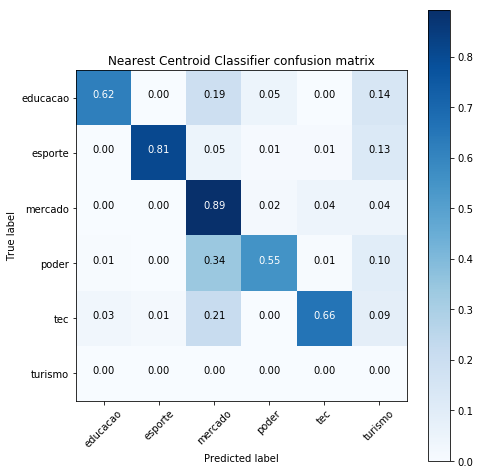

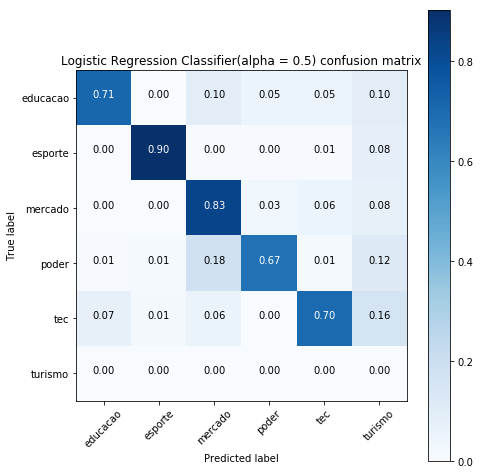

In [15]:
n = len(news)

for name in models:
    model = models[name]
    score = 0
    y_predict = []
    for new, label in zip(news,labels):
        y = model.predict(new) 
        if len(y) == 1:
            y = y[0]
            
        y_predict.append(y)

        if y == label:
            score += 1
    
    print("{}'s score: {}%".format(name,score*100/n))
    
    cnf_matrix = confusion_matrix(labels, y_predict)
    np.set_printoptions(precision=2)

    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='{} confusion matrix'.format(name))

### Quem sabe faz ao vivo!

Podemos também criar uma nova notícia e ver como os modelos se comportam!

In [16]:
new = """
fortaleza foi campeão da série B ao ganhar a partida por 1 x 0 contra o avaí e houve quebra quebra no estádio
"""

classify_new(new)

Gaussian Naive Bayes: esporte
Multinomial Naive Bayes: esporte
Bernoulli Naive Bayes: tec
Nearest Centroid Classifier: esporte
Logistic Regression Classifier(alpha = 0.5): esporte
